# Implement smooth covariates 

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

rng = np.random.default_rng(42)

# load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

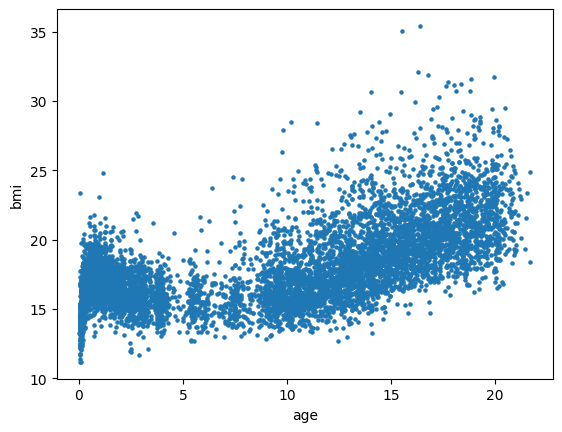

In [2]:
# plot the data
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [3]:
# set up design matrix 
X = tiger.Obs(name="X_loc", intercept=False)
X.smooth(data=df["age"].to_numpy())

# set up hyperparameters for the beta_scale  
tau_a = tiger.Hyper(0.01, name="tau_a")
tau_b = tiger.Hyper(0.01, name="tau_b")
tau_dist = tiger.Dist(tfd.InverseGamma, concentration=tau_a, scale=tau_b)
tau = tiger.Param(value=1.0, distribution=tau_dist, param_space="positive", name="tau")

# set up hyperparameters
beta_smooth_loc = tiger.Hyper(np.zeros(X.smooth_dim[0]), name="beta_smooth_loc")

# define the penaly matrix from class Obs
pen = X.smooth_pen_mat[0]

# set up parameters 
beta_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=beta_smooth_loc, scale=tau, pen=pen)
beta_smooth = tiger.Param(value=jnp.repeat(jnp.array([20.0]), X.smooth_dim[0]), distribution=beta_smooth_dist, name="beta_smooth")

# set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# set up the linear predictor 
lpred = tiger.Lpred(Obs=X, beta_smooth=beta_smooth)

# set up response distribution
response_dist = tiger.Dist(tfd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

## Implement the centering constraints

In [3]:
# define a model with intercept 
# set up design matrix 
X = tiger.Obs(name="X_loc", intercept=True)
X.smooth(data=df["age"].to_numpy())
# If we combine fixed covariates and smooth covariates we need to center the the 
# smooth effects first 
X.center()

# fixed coefficents 
# set up beta_fixed hyperparameters 
beta_fixed_loc = tiger.Hyper(0.0, name="beta_fixed_loc")
beta_fixed_scale = tiger.Hyper(100.0, name="beta_fixed_scale")

# set up parameters
beta_fixed_dist = tiger.Dist(tfd.Normal, loc=beta_fixed_loc, scale=beta_fixed_scale)
beta_fixed = tiger.Param(value=df["bmi"].to_numpy().mean(), distribution=beta_fixed_dist, name="beta_fixed")

# smooth coefficients
# set up hyperparameters for the beta_smooth_scale  
tau_a = tiger.Hyper(0.01, name="tau_a")
tau_b = tiger.Hyper(0.01, name="tau_b")
tau_dist = tiger.Dist(tfd.InverseGamma, concentration=tau_a, scale=tau_b)
tau = tiger.Param(value=jnp.array([1.0]), distribution=tau_dist, param_space="positive", name="tau")

# smooth coefficients
# ----
# Easy way with the normal
# set up beta_fixed hyperparameters 
# beta_smooth_loc = tiger.Hyper(0.0, name="beta_smooth_loc")

# set up parameters 
# beta_smooth_dist = tiger.Dist(tfd.Normal, loc=beta_smooth_loc, scale=tau)
# beta_smooth = tiger.Param(internal_value=jnp.repeat(jnp.array([0.0]), X.smooth_dim[0]), distribution=beta_smooth_dist, name="beta_smooth")
# ----

# set up smooth coefficients with mvn degenerate 
# set up hyperparameters
beta_smooth_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[0]), name="beta_smooth_loc")

# define the penalty matrix 
pen = X.smooth_pen_mat_cent[0]

# set up parameters 
beta_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=beta_smooth_loc, scale=tau, pen=pen)
beta_smooth = tiger.Param(value=np.zeros(X.smooth_dim_cent[0]), distribution=beta_smooth_dist, name="beta_smooth")

# set up the linear predictor
lpred = tiger.Lpred(Obs=X, beta_fixed=beta_fixed, beta_smooth=beta_smooth)

# set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# set up response distribution
response_dist = tiger.Dist(tfd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

In [4]:
m.log_prob

Array(-23833.168, dtype=float32)

In [5]:
graph = tiger.ModelGraph(Model=m)
graph.build_graph()

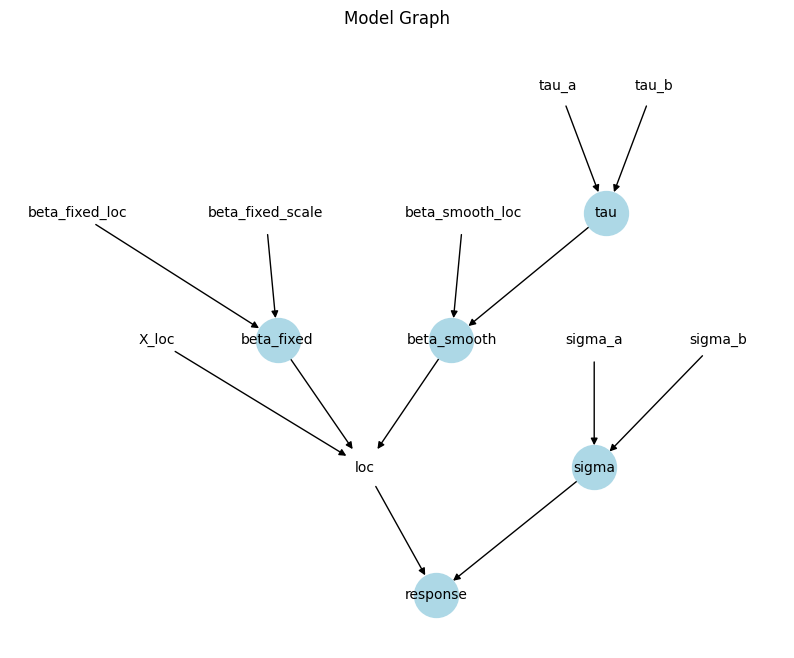

In [6]:
graph.visualize_graph()

# Allow for joint variational distribution

In [28]:
def init_variational_params(joint_nodes: str):
    nodes = joint_nodes.split("_")
    mu = []
    diag = []
    for node in nodes:
        attr = graph.DiGraph.nodes[node]["attr"]
        input = graph.DiGraph.nodes[node]["input"]
        mu.append(attr["internal_value"])
        diag.append(jnp.ones(attr["dim"])*1.25)
    
    mu = jnp.concatenate(mu)
    lower_tri = jnp.diag(jnp.concatenate(diag))

    return {"mu": mu, "lower_tri": lower_tri}

In [ ]:
variational_params = {}
included = []

In [ ]:
for node in reversed(graph.prob_traversal_order):
    node_type = graph.DiGraph.nodes[node].get("node_type")
    if node_type == "strong" and node not in included:
        included.append(node)
        neighbours = list(graph.DiGraph.predecessors(node))
        neighbours_param = []
        for neighbour in neighbours:
            neighbour_node_type = graph.DiGraph.nodes[neighbour].get("node_type")
            if neighbour_node_type == "strong":
                neighbours_param.append(neighbour)
        
        included.extend(neighbours_param)
        if len(neighbours_param) >= 1:
            name = node + "_" + "_".join(neighbours_param)
            variational_params[name] = init_variational_params(name)
        else:
            variational_params[node] = init_variational_params(node)

In [41]:
variational_params

NameError: name 'variational_params' is not defined

In [ ]:
for key in joint_distributions.keys():
    print(key.split("_"))

In [ ]:
test = ["tau", "sigma"]
test.extend(["beta", "alpha"])
test

In [ ]:
graph.DiGraph.nodes["sigma"]["attr"]

## Inference with BBVI

In [7]:
q = bbvi.Bbvi(Graph=graph, key=27, batch_size=1024, num_samples=64)

In [8]:
q.run_bbvi(step_size=0.05, threshold=1e-5, chunk_size=25, num_iterations=10000)

(Array(-2249.6868, dtype=float32),
 {'beta_fixed': {'loc': Array([18.071568], dtype=float32),
   'cov': Array([[0.01114993]], dtype=float32)},
  'tau': {'loc': Array([-1.1124444], dtype=float32),
   'cov': Array([[0.03962272]], dtype=float32)},
  'sigma': {'loc': Array([0.7751294], dtype=float32),
   'cov': Array([[0.00991971]], dtype=float32)},
  'beta_smooth': {'loc': Array([-2.1803298, -2.1477327, -2.674433 , -2.520639 , -2.3342862,
          -2.1038995, -1.8298606, -1.4554669, -1.0536432, -0.5996562,
          -0.0816331,  0.4650256,  1.0379676,  1.6001878,  2.145196 ,
           2.7273805,  3.2677693,  3.693133 ,  4.0207415], dtype=float32),
   'cov': Array([[ 7.93491453e-02,  2.22826991e-02,  4.44717705e-03,
           -1.24217486e-02,  6.39419188e-04,  1.70256547e-03,
            4.50807915e-04,  4.43570409e-03, -3.92032927e-03,
           -4.08589840e-03, -1.06074298e-02, -9.40646138e-03,
           -1.31313037e-02, -1.37948506e-02, -1.11145731e-02,
           -8.43004137e-03, 

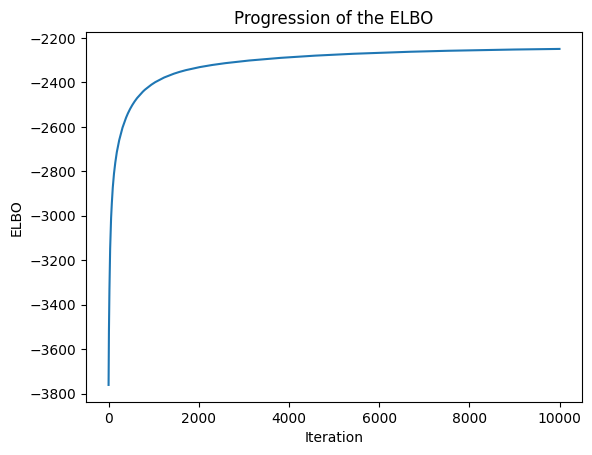

In [11]:
q.plot_elbo()

## Visualize the regression line 

In [19]:
# plot the regression line 
b = q.opt_variational_params["beta_smooth"]["loc"]
x_new = jnp.linspace(df["age"].to_numpy().min(), df["age"].to_numpy().max(), num=100)
X_new = tiger.Obs(name="X_pred", intercept=False)
X_new.smooth(data = x_new)
y = X_new.design_matrix @ b

In [13]:
# for fixed and smooth terms
b_fixed = q.opt_variational_params["beta_fixed"]["loc"]
b_smooth = q.opt_variational_params["beta_smooth"]["loc"]
b = jnp.concatenate((b_fixed, b_smooth))
y = X.design_matrix @ b

In [16]:
b_smooth.shape

(19,)

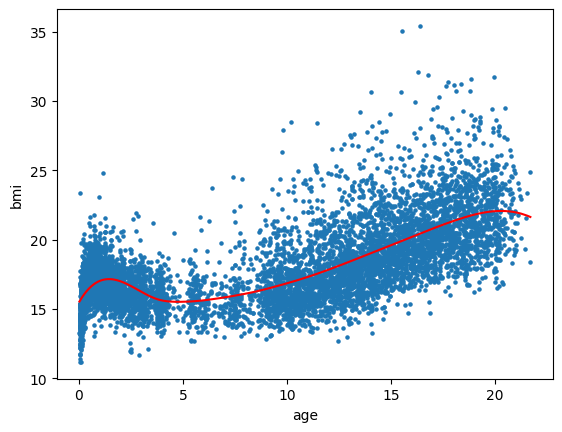

In [19]:
# plot the data
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
# ax.plot(x_new, y, color = "r")
ax.plot(df["age"].to_numpy(), y, color = "r")
plt.show()

In [20]:
tau = q.opt_variational_params["tau"]["loc"]
s = q.opt_variational_params["tau"]["cov"]

In [21]:
m = jnp.exp(tau + s/2)

In [22]:
1 / (m ** 2)

Array([[8.893014]], dtype=float32)